In [6]:
# this is the preliminary work so that you have a function that gives testing and diagnosis rates per person per unit time

from numpy import *
from sympy import *

##############################
# function to calculate steady-state A, U and S
##############################

Af, As, U, Sf, Ss = symbols("Af As U Sf Ss")
alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU  = symbols("alpha_UAf alpha_UAs alpha_AfU alpha_AsU alpha_USf alpha_USs alpha_SfU alpha_SsU")

model_dyn = [
    alpha_UAf*U - alpha_AfU*Af, # asymptomatic infected fast clearance
    alpha_UAs*U - alpha_AsU*As, # asymptomatic infected slow clearance
    alpha_AfU*Af + alpha_SfU*Sf + alpha_AsU*As + alpha_SsU*Ss - (alpha_UAf + alpha_UAs + alpha_USf + alpha_USs)*U, # uninfected
    alpha_USf*U - alpha_SfU*Sf, # symptomatic infected fast clearance
    alpha_USs*U - alpha_SsU*Ss, # symptomatic infected slow clearance
    Af + As + U + Sf + Ss - 1
    ]

sol_dyn = solve(model_dyn, Af, As, U, Sf, Ss)
print sol_dyn

{As: alpha_AfU*alpha_SfU*alpha_SsU*alpha_UAs/(alpha_AfU*alpha_AsU*alpha_SfU*alpha_SsU + alpha_AfU*alpha_AsU*alpha_SfU*alpha_USs + alpha_AfU*alpha_AsU*alpha_SsU*alpha_USf + alpha_AfU*alpha_SfU*alpha_SsU*alpha_UAs + alpha_AsU*alpha_SfU*alpha_SsU*alpha_UAf), Af: alpha_AsU*alpha_SfU*alpha_SsU*alpha_UAf/(alpha_AfU*alpha_AsU*alpha_SfU*alpha_SsU + alpha_AfU*alpha_AsU*alpha_SfU*alpha_USs + alpha_AfU*alpha_AsU*alpha_SsU*alpha_USf + alpha_AfU*alpha_SfU*alpha_SsU*alpha_UAs + alpha_AsU*alpha_SfU*alpha_SsU*alpha_UAf), U: alpha_AfU*alpha_AsU*alpha_SfU*alpha_SsU/(alpha_AfU*alpha_AsU*alpha_SfU*alpha_SsU + alpha_AfU*alpha_AsU*alpha_SfU*alpha_USs + alpha_AfU*alpha_AsU*alpha_SsU*alpha_USf + alpha_AfU*alpha_SfU*alpha_SsU*alpha_UAs + alpha_AsU*alpha_SfU*alpha_SsU*alpha_UAf), Ss: alpha_AfU*alpha_AsU*alpha_SfU*alpha_USs/(alpha_AfU*alpha_AsU*alpha_SfU*alpha_SsU + alpha_AfU*alpha_AsU*alpha_SfU*alpha_USs + alpha_AfU*alpha_AsU*alpha_SsU*alpha_USf + alpha_AfU*alpha_SfU*alpha_SsU*alpha_UAs + alpha_AsU*alpha_SfU*al

In [7]:
U_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), sol_dyn[U])
Af_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), sol_dyn[Af])
As_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), sol_dyn[As])
Sf_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), sol_dyn[Sf])
Ss_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), sol_dyn[Ss])
dyn_fun = lambdify((alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU), 1 - sol_dyn[U])

In [66]:
##############################
# now the model for observed testing and diagnosis rates
##############################

tsym, dsym, ssym, test_sym, true_pos, false_pos = symbols("tsym dsym ssym test_sym true_pos false_pos")

model_test_diag = [
    tsym - ( ssym + (1 - Af - As - U)*test_sym ), # total testing rate
    dsym - ( (Af + As)*ssym*true_pos + U*ssym*false_pos + (1 - Af - As - U)*test_sym*true_pos ) # total diagnosis rate
    ]

sol_prev = solve(model_test_diag, ssym, U)
sol_test_diag = solve(model_test_diag, tsym, dsym)
test_fun = lambdify((Af, As, U, ssym, test_sym, true_pos, false_pos), sol_test_diag[tsym])
diag_fun = lambdify((Af, As, U, ssym, test_sym, true_pos, false_pos), sol_test_diag[dsym])

def test_diag_fun(parms):
    # parms = (incidence, screening rate, proportion symptomatic, self-cure rate, testing rate in symptomatics, true positive rate, false positive rate, ...)
    inc = parms[0]
    scr = parms[1]
    p_symp = parms[2]
    p_fast = parms[3]
    self_cure_f = parms[4]
    self_cure_s = parms[5]
    test_sym = parms[6]
    true_pos = parms[7]
    false_pos = parms[8]
    
    Af = Af_fun(inc*(1-p_symp)*p_fast, inc*(1-p_symp)*(1-p_fast), self_cure_f + scr*true_pos, self_cure_s + scr*true_pos, inc*p_symp*p_fast, inc*p_symp*(1-p_fast), self_cure_f + scr*true_pos + test_sym*true_pos, self_cure_s + scr*true_pos + test_sym*true_pos)
    As = As_fun(inc*(1-p_symp)*p_fast, inc*(1-p_symp)*(1-p_fast), self_cure_f + scr*true_pos, self_cure_s + scr*true_pos, inc*p_symp*p_fast, inc*p_symp*(1-p_fast), self_cure_f + scr*true_pos + test_sym*true_pos, self_cure_s + scr*true_pos + test_sym*true_pos)
    U = U_fun(inc*(1-p_symp)*p_fast, inc*(1-p_symp)*(1-p_fast), self_cure_f + scr*true_pos, self_cure_s + scr*true_pos, inc*p_symp*p_fast, inc*p_symp*(1-p_fast), self_cure_f + scr*true_pos + test_sym*true_pos, self_cure_s + scr*true_pos + test_sym*true_pos)
    return [test_fun(Af, As, U, scr, test_sym, true_pos, false_pos), diag_fun(Af, As, U, scr, test_sym, true_pos, false_pos)]
    

In [80]:
from numpy import *
from scipy.optimize import fsolve
n_sample = 10000
rs = random.RandomState(12345)


In [177]:
p_asymp_f = rs.beta(135 + 1, 26 + 1, size=n_sample) # Kahn et al. Sex Transm Dis (2003) 84% NB numbers taken from text, p656
sc_f = 120*ones(n_sample)
p_true_pos_f = rs.beta(129+1, 12+1, size=n_sample) # Low Health Technol Assess (2007): 129 of 141 infected samples tested +ve
p_false_pos_f = rs.beta(4+1, 2323+1, size=n_sample) # Low Health Technol Assess (2007): 4 of 2327 uninfected samples tested +ve
p_fast = 0.23*ones(n_sample) # for the moment

In [178]:
# Alternatively, read in stan samples.

sc_s = empty(n_sample) # testing rate per person per year

import csv
with open('../chlamydia_two_exponentials_init0_280416.csv', 'rU') as f:
    reader = csv.reader(f)
    i=0
    for row in reader:
        if i < n_sample:
            sc_s[i] = row[0]
            i = i+1

In [179]:
from scipy.stats import beta

# Find beta distributions corresponding to 95% CIs reported in Mercer Sex. Transm. Infect. (2007) (see table above).

a = empty(5)
b = empty(5)

# < 1 week
[a[0], b[0]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.144, 0.442),
    [1,1]
    )

# 7-13 days
[a[1], b[1]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.061, 0.302),
    [1,1]
    )

# 14-27 days
[a[2], b[2]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.133, 0.310),
    [1,1]
    )

# 28-41 days
[a[3], b[3]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.085, 0.299),
    [1,1]
    )

# 42 days and over
[a[4], b[4]] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.055, 0.564),
    [1,1]
    )

# Metropolis-Hastings to get a sample for rate of treatment

i = 0
att_symp = empty(n_sample+1000) # testing rate per person per year. Allow 1000 extra samples for burn-in
ll = empty(n_sample+1000) # log-likelihood
props = empty([n_sample+1000, 5]) # simulated data, for posterior predictive check
old = 0.04 # starting sample value
new = 0.04 # starting sample value

# simulate probabilities corresponding to data

# proportion expected in each time window
tps = array([0., 7., 14., 28., 42., Inf])
simp_old = exp(-old*tps[:5]) - exp(-old*tps[1:])
simp_new = exp(-new*tps[:5]) - exp(-new*tps[1:])

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = rs.normal(old, 0.05) # generate a sample from normal distribution
    
    if new < 0:
        att_symp[i] = old # reject
        ll[i] = -1e10
    else:
        simp_old = exp(-old*tps[:5]) - exp(-old*tps[1:])
        simp_new = exp(-new*tps[:5]) - exp(-new*tps[1:])

        if sum(simp_new > 0) != len(tps) - 1:
            att_symp[i] = old # reject
            ll[i] = -1e10
        else:
            # simulate probabilities corresponding to the data
            log_ratio = sum(beta.logpdf(simp_new, a, b, loc=0, scale=1)) - sum(beta.logpdf(simp_old, a, b, loc=0, scale=1))
    
            if log(rs.uniform(0,1)) <  log_ratio:
                att_symp[i] = new # accept
                ll[i] = sum(beta.logpdf(simp_new, a, b, loc=0, scale=1))
                old = new
                acc = acc+1
            else:
                att_symp[i] = old # reject
                ll[i] = sum(beta.logpdf(simp_old, a, b, loc=0, scale=1))
    
    props[i] = simp_old
    i = i+1
    
att_symp = att_symp[1000:] # remove burn-in samples
ll = ll[1000:] # log-likelihood
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(att_symp)*365.25
print array(percentile(att_symp, [2.5, 97.5]))*365.25

att_symp = att_symp*365.25 # convert rate from day^-1 to year^-1

0.230454545455
14.2322571095
[  8.5488437   21.91982901]


In [180]:
# women, 16-24
[alpha_f_16_24, beta_f_16_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.7998634469, 0.837979601),
    [1,1]
    )
p_active_f_16_24 = rs.beta(alpha_f_16_24, beta_f_16_24, size=n_sample) # 16-24 yo only
pop_active_f_15_24 = rs.binomial(3388842, p_active_f_16_24, size=n_sample)

diag_rate_f_15_24 = rs.gamma(88101, 1, size=n_sample)/pop_active_f_15_24
test_rate_f_15_24 = rs.gamma(1205896, 1, size=n_sample)/pop_active_f_15_24

In [181]:
prev_f_15_24 = zeros(n_sample)
inc_f_15_24 = zeros(n_sample)
scr_f_15_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_24[i], scr_f_15_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            p_fast[i], # proportion of incident infections which clear fast
                            sc_f[i], # fast rate of self-clear 
                            sc_s[i], # slow rate of self-clear 
                            att_symp[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_24[i],diag_rate_f_15_24[i]]), [0.03, 0.44])
    prev_f_15_24[i] = dyn_fun(
        inc_f_15_24[i]*p_asymp_f[i]*p_fast[i], 
        inc_f_15_24[i]*p_asymp_f[i]*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i], 
        sc_s[i] + scr_f_15_24[i]*p_true_pos_f[i], 
        inc_f_15_24[i]*(1-p_asymp_f[i])*p_fast[i], 
        inc_f_15_24[i]*(1-p_asymp_f[i])*(1-p_fast[i]), 
        sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i],
        sc_s[i] + scr_f_15_24[i]*p_true_pos_f[i] + att_symp[i]*p_true_pos_f[i]
    )

median for sexually active women, 15-24 years: 0.0531761418876
95% CI for sexually active women, 15-24 years: 0.0452712924742 0.0609420721058


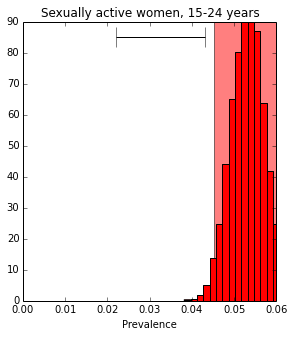

In [182]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10,5))

# ax1 = fig.add_subplot(121)
# h_2012_m_15_24 = ax1.hist(prev_m_15_24, bins=20, normed=true, color='b')
# ax1.fill_betweenx([0,100], percentile(prev_m_15_24, 2.5), percentile(prev_m_15_24, 97.5), facecolor='b', alpha=0.5)
# ax1.errorbar(0.015, 85, xerr=[[0],[0.034-0.015]], ecolor='k', capsize=10)
# ax1.set_xlabel('Prevalence')
# ax1.set_xlim(0,0.06)
# ax1.set_ylim(0,90)
# ax1.set_title('Sexually active men, 15-24 years')

# print '95% CI for sexually active men, 15-24 years:', percentile(prev_m_15_24, 2.5), percentile(prev_m_15_24, 97.5)

ax2 = fig.add_subplot(122)
h_2012_f_15_24 = ax2.hist(prev_f_15_24, range=[min(prev_f_15_24),max(prev_f_15_24)], bins=20, normed=true, color='r')
ax2.fill_betweenx([0,100], percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5), facecolor='r', alpha=0.5)
ax2.errorbar(0.022, 85, xerr=[[0],[0.043-0.022]], ecolor='k', capsize=10)
ax2.set_xlabel('Prevalence')
ax2.set_xlim(0,0.06)
ax2.set_ylim(0,90)
ax2.set_title('Sexually active women, 15-24 years')

print 'median for sexually active women, 15-24 years:', percentile(prev_f_15_24, 50)
print '95% CI for sexually active women, 15-24 years:', percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5)

In [ ]:
(alpha_UAf, alpha_UAs, alpha_AfU, alpha_AsU, alpha_USf, alpha_USs, alpha_SfU, alpha_SsU)